파이썬으로 이미지 파일 다루기
======

- Pillow와 OpenCV로 Python에서 이미지 파일을 열고 정보를 추출해본다.


## Pillow 사용하기

### PIL을 이용해 이미지 하나를 직접 생성해 보기

명심할 점은 결국 이미지는 배열 형태의 데이터라는 점입니다.     
           
예를 들어 가로 세로 각 32픽셀에 RGB 세 가지 색상 채널이 있다면, Numpy로 [32, 32, 3] 차원의 배열을 생성하면 됩니다. 또한 데이터 타입을 uint8, 즉 각 값이 부호가 없는(unsigned) 8비트 정수(integer)가 되어 0~255(2의 8승 = 256) 사이의 값을 나타내도록 해야 합니다.

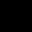

In [1]:
# 만들어진 배열을 PIL.Image.fromarray()를 통해 바로 이미지 객체로 변환한 뒤
# 화면에 표시
import numpy as np
from PIL import Image

data = np.zeros([32, 32, 3], dtype=np.uint8)
image = Image.fromarray(data, 'RGB')
image

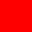

In [2]:
# 모든 픽셀이 빨간색의 값을 갖도록 저장
data[:, :] = [255, 0, 0]
image = Image.fromarray(data, 'RGB')
image

### 연습 문제

### 1) 가로 세로 각 128 픽셀짜리 흰색 이미지를 만들어 화면에 표시해 봅시다.

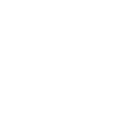

In [3]:
data = np.zeros([128, 128, 3], dtype=np.uint8)
data[:, :] = [255, 255, 255]
image = Image.fromarray(data, 'RGB')
image

### 2) 연습용 이미지를 열어 width와 height를 출력하고, .save()를 이용하여 jpg 파일 포맷으로 저장해 봅시다.

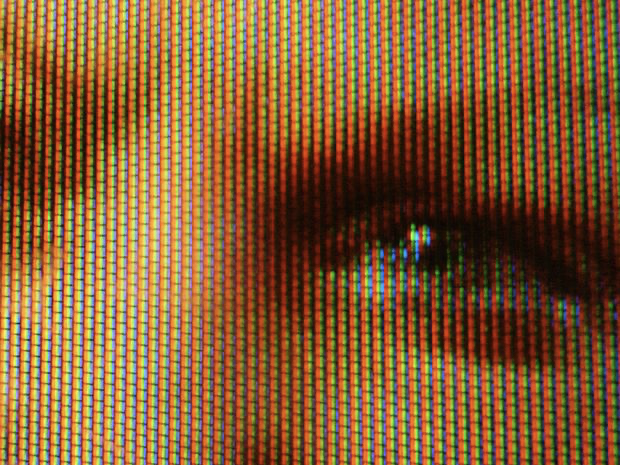

In [4]:
from PIL import Image
import os

# 연습용 파일 경로
image_path = os.getenv('HOME')+'/aiffel/Fundamentals/F12_python_image_proc/data/pillow_practice.png'

# 이미지 열기
img = Image.open(image_path)
img

In [5]:
# width와 height 출력
print(img.width)
print(img.height)

# JPG 파일 형식으로 저장해보기
new_img_path = os.getenv('HOME')+'/aiffel/Fundamentals/F12_python_image_proc/data/new_pillow_practice.jpg'
img = img.convert('RGB')
img.save(new_img_path)

620
465


### 3) .resize()를 이용하여 이미지 크기를 100X200으로 변경하여 저장해봅시다.

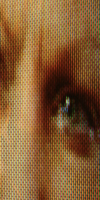

In [6]:
resized_img = img.resize((100,200))

resized_img_path = os.getenv('HOME')+'/aiffel/Fundamentals/F12_python_image_proc/data/resized_pillow_practice.png'
resized_img.save(resized_img_path)
resized_img

### 4) .crop()을 이용하여 눈 부분만 잘라내어 저장해 봅시다.
(힌트) 눈 부분의 box 좌표는 (300, 100, 600, 400)입니다.

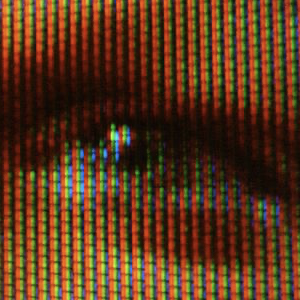

In [7]:
box = (300, 100, 600, 400)
region = img.crop(box)

cropped_img_path = os.getenv('HOME')+'/aiffel/Fundamentals/F12_python_image_proc/data/pillow_practice_cropped.png'
region.save(cropped_img_path)
region

## Pillow를 활용한 데이터 전처리

### CIFAR-100 데이터를 받아 개별 이미지 파일로 추출하기
- 이미지 데이터베이스 구축을 위해 CIFAR-100 데이터셋 을 활용해보겠습니다. 32x32 화소 해상도의 이미지들이 100개 클래스 당 600장(각 학습용 500장, 테스트용 100장)하여 총 60,000장 있습니다.
- https://www.cs.toronto.edu/~kriz/cifar.html
- Dataset layout 아래 Python / Matlab versions 섹션 중 python3 버전에 따라 한번 파일을 열어봅시다. 그렇게 해서 추출된 내용(return dict에 의해 반환된 내용)을 train이라고 하고 한번 들여다봅시다.

In [8]:
import os
import pickle
from PIL import Image

dir_path = os.getenv('HOME')+'/aiffel/Fundamentals/F12_python_image_proc/data/cifar-100-python'
train_file_path = os.path.join(dir_path, 'train')

with open(train_file_path, 'rb') as f:
    train = pickle.load(f, encoding='bytes')

print(type(train))
#print(train)   # 혹시 내용이 궁금하다면 주석을 풀고 실행해 보세요.

<class 'dict'>


In [9]:
train.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

- 특이사항으로는 각 키들이 문자열(str)이 아닌 b로 시작하는 bytes로 되어있다는 점입니다. 

In [10]:
type(train[b'filenames'])

list

In [11]:
train[b'filenames'][0:5]

[b'bos_taurus_s_000507.png',
 b'stegosaurus_s_000125.png',
 b'mcintosh_s_000643.png',
 b'altar_boy_s_001435.png',
 b'cichlid_s_000031.png']

In [12]:
train[b'data'][0:5]

array([[255, 255, 255, ...,  10,  59,  79],
       [255, 253, 253, ..., 253, 253, 255],
       [250, 248, 247, ..., 194, 207, 228],
       [124, 131, 135, ..., 232, 236, 231],
       [ 43,  32,  87, ...,  60,  29,  37]], dtype=uint8)

In [13]:
train[b'data'][0].shape

(3072,)

-  3072라는 숫자는 빨강 초록 파랑 3채널 X 1024(=32 * 32)씩 각 화소에 해당하는 것 같습니다. 그렇다면 이 Numpy 배열을 잘 reshape하면 이미지 파일 원본이 복구된다는 뜻입니다.
- 주의해야 할 게 하나 있습니다. 위에 언급된 바를 상기해 보면, 3072바이트의 이미지 데이터는 앞 1024바이트는 빨강(R), 그다음 1024는 녹색(G), 마지막 1024는 파랑(B)으로 되어 있습니다. RGB 순서가 맞는 것은 다행이지만, 그렇다고 그냥 모양만 맞추어 reshape하면 안 됩니다. 1024를 32X32에 채우는 것을 3번 반복하는 방식의 reshape이어야 합니다. 이렇게 앞선 차원부터 데이터를 채우는 방식의 reshape를 위해 np.reshape에는 order라는 인자가 있습니다. 이 값을 F로 주면 원하는 형태로 진행됩니다.

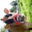

In [14]:
image_data = train[b'data'][0].reshape([32, 32, 3], order='F')   # order를 주의하세요!!
image = Image.fromarray(image_data)    # Pillow를 사용하여 Numpy 배열을 Image객체로 만들어서
image    # 화면에 띄워 봅시다!!

- 이미지의 X축과 Y축이 뒤집어져 나오고 있습니다. 축을 바꿔주는 작업이 필요합니다.
여기에는 np.swapaxes(0, 1)이 유용합니다.

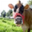

In [15]:
image_data = image_data.swapaxes(0, 1)
image = Image.fromarray(image_data)
image

자, 이렇게 CIFAR-100의 데이터셋 원본을 분석해서 이미지 파일을 뽑아내는 것까지 진행해 보았습니다. 그러나 우리는 이미지 파일을 실제 파일처럼 만들어 놓고 싶습니다. 데이터셋에 파일명과 파일 데이터 배열이 순서를 따라 저장되어 있는 것을 확인하였으니, 차례차례 Numpy 배열로 읽어서 이를 이미지 파일로 저장해 주겠습니다.

- (참고) tqdm을 사용하면 반복 작업의 진행 상황을 시각화해서 체크해 볼 수 있습니다. 

In [16]:
# 차례차례 Numpy 배열로 읽어서 이를 이미지 파일로 저장해 주기
import os
import pickle
from PIL import Image
import numpy
from tqdm import tqdm

dir_path = os.getenv('HOME')+'/aiffel/Fundamentals/F12_python_image_proc/data/cifar-100-python'
train_file_path = os.path.join(dir_path, 'train')

# image를 저장할 cifar-100-python의 하위 디렉토리(images)를 생성합니다. 
images_dir_path = os.getenv('HOME')+'/aiffel/Fundamentals/F12_python_image_proc/cifar-images'
if not os.path.exists(images_dir_path):
    os.mkdir(images_dir_path)  # images 디렉토리 생성

# 32X32의 이미지 파일 50000개를 생성합니다. 
with open(train_file_path, 'rb') as f:
    train = pickle.load(f, encoding='bytes')
    for i in tqdm(range(len(train[b'filenames']))):
        filename = train[b'filenames'][i].decode()
        data = train[b'data'][i].reshape([32, 32, 3], order='F')
        image = Image.fromarray(data.swapaxes(0, 1))
        image.save(os.path.join(images_dir_path, filename))

100%|██████████| 50000/50000 [00:22<00:00, 2210.05it/s]


## OpenCV 사용하기

- OpenCV는 오픈소스로 제공되는 컴퓨터 비전용 라이브러리인데요. C++, Python, Java, MATLAB 등 다양한 언어에서 호출하여 사용할 수 있으며, 영상 처리에 대한 다양한 고급 기능들이 사용하기 쉽도록 구현되어 있습니다.
- 튜토리얼: https://docs.opencv.org/master/d6/d00/tutorial_py_root.html

### 예제 

이미지를 읽어 들이고, 파란색을 찾기 쉽도록 컬러스페이스를 BGR(RGB)에서 HSV로 변환한 뒤, 해당 색상과 맞는 영역만 표시하는 작업이 진행됩니다.

(1280, 1920, 3)


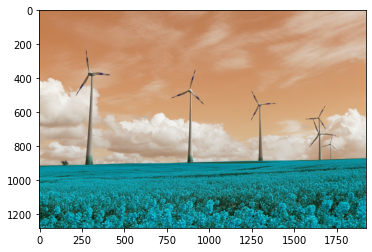

In [17]:
import os
import cv2 as cv
import numpy as np
from  matplotlib import pyplot as plt
%matplotlib inline

img_path = os.getenv('HOME')+'/aiffel/Fundamentals/F12_python_image_proc/data/cv_practice.png'
img = cv.imread(img_path)

print(img.shape)
# OpenCV에서는 RGB가 아닌 BGR 순서를 사용
plt.imshow(img)

- imread는 말 그대로 파일로부터 이미지를 읽어와 반환해 주는 함수입니다.
- cv.imread()     
    https://docs.opencv.org/4.5.2/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56

In [18]:
# Convert BGR to HSV
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

- cvtColor은 컬러 스페이스 변환(convert)을 위한 함수입니다. 
- cv.cvtColor()     
    https://docs.opencv.org/master/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab

In [19]:
# define range of blue color in HSV
lower_blue = np.array([100,100,100])
upper_blue = np.array([130,255,255])

# Threshold the HSV image to get only blue colors
mask = cv.inRange(hsv, lower_blue, upper_blue)

- 숫자로 파란색이라는 부분을 정의하고, 이 값들을 기준으로 이미지에서 마스크를 생성하는 과정입니다. 우리가 원하는 부분만을 떼어낼 수 있도록 하는 역할입니다.
- 위 코드에서는 HSV 색 공간에서 색상(Hue) 값 110\~130 사이, 채도(Saturation) 및 명도(Value) 값 5\~255 사이의 색들을 파란색이라고 정의하고 있습니다. 
- 그리고 아까 img 를 변환한 hsv에다가 이 기준들(lower_blue, upper_blue)를 적용하여, 해당하는 픽셀들에는 1, 그렇지 않은 픽셀들에는 0을 찍어놓은 배열을 반환하는 것이 cv.inRange()의 역할입니다.

- 즉, 우리가 가로 400, 세로 300 픽셀짜리 이미지를 받았었다면, img과 hsv는 각각 픽셀 당 BGR, HSV 세 개의 색상 채널별 값을 가질 테기 때문에, 400 * 300 * 3의 크기를 갖는 배열이었고, mask는 픽셀마다 1 또는 0만을 값으로 가졌기에 400 * 300 (* 1)의 크기를 갖게 됩니다.

In [20]:
# Bitwise-AND mask and original image
res = cv.bitwise_and(img, img, mask=mask)

- cv.bitwise_and()    
    https://docs.opencv.org/3.4/d2/de8/group__core__array.html#ga60b4d04b251ba5eb1392c34425497e14
- 결국 이미지 두 장을 받아서 AND 비트 연산을 한다는 건데, 우리는 이 기능이 필요한 게 아니니 두 장 다 같은 이미지(img, img)를 넣어서 결국 동일한 이미지가 나오게 합니다. 대신 중요한 mask를 같이 넣어줘서, 해당 영역만 따오도록 합니다. 따온 영역은 위 공식 문서 페이지의 함수 설명에 따라 dst가 주어진다면 그 위에, 아니면 새로 빈 검정색 영역 위에 이미지를 만들고 반환합니다.

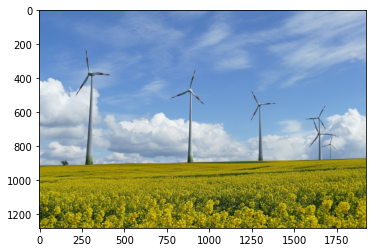

In [21]:
# BGR --> RGB
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()

- OpenCV에서는 RGB가 아닌 BGR 순서를 사용합니다. 따라서 plt 로 이미지를 보여줄 땐 cv.cvtColor(res, cv.COLOR_BGR2RGB) 함수를 통해, cv 이미지 객체의 컬러를 변환해 줘야 합니다.

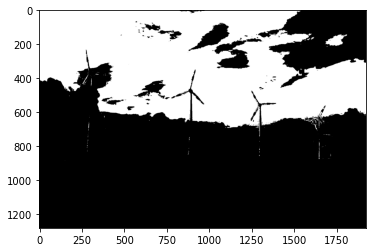

In [22]:
plt.imshow(cv.cvtColor(mask, cv.COLOR_BGR2RGB))
plt.show()

- 파란색인 영역만 골라낸 마스크 mask를 출력합니다. 

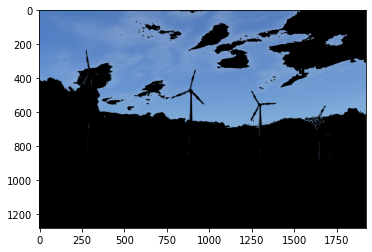

In [23]:
plt.imshow(cv.cvtColor(res, cv.COLOR_BGR2RGB)) 
plt.show() 

- 이미지에 마스크를 적용한 결과 res를 표시하도록 합니다.
   
   
- 혹은, 굳이 plt 로 보여주지 않고 cv 로 이미지를 띄우는 방법도 있습니다. cv.imshow(res) 도 PIL.Image.show(), plt.imshow()와 마찬가지로 이미지를 화면에 표시해 줍니다.